In [5]:
import os
import sys
sys.path.append(os.getcwd())

In [152]:
import pandas as pd
import sentiment
from sklearn.metrics import confusion_matrix as cm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from sklearn.metrics import classification_report as clr
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import f1_score
from scipy.special import softmax

In [156]:
def discretize(x,h,l):
    h=l+abs(h)
    if x>=h:
        return 1
    elif x<=l:
        return -1
    else:
        return 0

In [153]:
def loss(weights,x,y_true,h,l):
    w1,w2,w3=softmax(weights)
    s=x[:,0]*w1+x[:,1]*w2+x[:,2]*w3
    y_pred=[discretize(v,h,l) for v in s]
    return -f1_score(y_true,y_pred,average='macro')

In [70]:
def actual(x):
    if x=='positive':
        return 1
    elif x=='negative':
        return -1
    else:
        return 0

In [155]:
def train(df,h,l):
    weights=np.array([0,0,0])
    res=minimize(loss,weights,args=(df[['vader','textblob','custom']].to_numpy(),df['num_sent'].to_numpy(),h,l),method='powell')
    #print(res.fun)
    return res

In [78]:
def loss2(bounds,df):
    res=train(df,bounds[1],bounds[0])
    return res.fun

In [154]:
def decidehl(df):
    init=np.array([-0.05,0.1])
    res=minimize(loss2,init,args=(df),method='powell')
    print(-res.fun)
    return res.x

In [11]:
file=pd.read_csv("all-data.csv",encoding_errors="ignore",header=None)
file.columns=['sentiment','feedback']

In [13]:
obj=sentiment.LexiconSentimentAnalyzer()

In [15]:
file[['vader','textblob','custom']]=file['feedback'].apply(obj.analyze).apply(pd.Series)[['vader score','textblob score','custom lexicon score']]
file

,sentiment,feedback,vader,textblob,custom
0,neutral,"According to Gran , the company has no plans t...",-0.1280,0.500000,0.000000
1,neutral,Technopolis plans to develop in stages an area...,-0.2960,0.541667,0.000000
2,negative,The international electronic industry company ...,0.0000,0.500000,0.000000
3,positive,With the new production plant the company woul...,0.8555,0.467599,0.033333
4,positive,According to the company 's updated strategy f...,0.6705,0.500000,0.060606
...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,-0.7269,0.250000,-0.039216
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0.0000,0.500000,0.000000
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,0.7430,0.500000,0.039216
4844,negative,Net sales of the Paper segment decreased to EU...,0.4404,0.520000,0.022989


In [17]:
file['num_sent']=file['sentiment'].apply(actual)

In [159]:
bounds=decidehl(file)
#bounds=[0,0.2]
weights=softmax(train(file,bounds[1],bounds[0]).x)
#weights=[1,0,0]
print(bounds)
print(weights)

0.5215814410237392
[0.07095925 0.12818392]
[0.25425328 0.16372489 0.58202183]


In [160]:
pred=(file['vader']*weights[0]+weights[1]*file['textblob']+weights[2]*file['custom']).apply(lambda x:discretize(x,bounds[1],bounds[0]))
pred

0      -1
1      -1
2       0
3       1
4       1
       ..
4841   -1
4842    0
4843    1
4844    1
4845   -1
Length: 4846, dtype: int64

In [161]:
true=file['sentiment'].apply(lambda x: actual(x))
true

0       0
1       0
2      -1
3       1
4       1
       ..
4841   -1
4842    0
4843   -1
4844   -1
4845   -1
Name: sentiment, Length: 4846, dtype: int64

In [162]:
matrix=cm(true,pred)
matrix

array([[ 220,  270,  114],
       [ 293, 2063,  523],
       [  80,  632,  651]], dtype=int64)

In [163]:
print(clr(true,pred,target_names=['negative','neutral','positive']))

              precision    recall  f1-score   support

    negative       0.37      0.36      0.37       604
     neutral       0.70      0.72      0.71      2879
    positive       0.51      0.48      0.49      1363

    accuracy                           0.61      4846
   macro avg       0.52      0.52      0.52      4846
weighted avg       0.60      0.61      0.60      4846



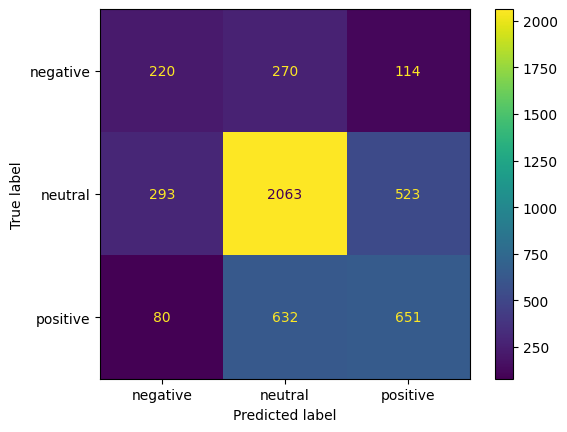

In [164]:
dis=cmd(confusion_matrix=matrix,display_labels=['negative','neutral','positive'])
dis.plot()
plt.show()